In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras import backend as K
import math
import matplotlib.pyplot as plt
import random



# Load data

In [2]:
#change current directory up to parent, only run 1 time!
os.chdir("..")

In [3]:
#loads data from clean_data 
#path need to be set to the clean_data folder
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1498):
    train_data_input=[]
    train_data_target=[]
    
    for n in range(nr_img):
        n1=n
        if test:
            n1=f'{n}_a'
        try:
            test1=np.load(f'{path}/{n1}.npy')
            inputs=test1[:3].transpose()#/255
            inputs=tf.convert_to_tensor(inputs)
            #inputs=inputs[tf.newaxis,...]
            target=test1[3].transpose()
            target=tf.convert_to_tensor(target)
            target=target[...,tf.newaxis]
            #target=target[tf.newaxis,...]

            
            train_data_input.append(inputs)
            train_data_target.append(target)
        except:
            if Print:
                print(f'fil nr {n} mangeler')
    return [train_data_input,train_data_target]

In [4]:
#Load test and train data
test_data=load_data(test=True)
train_data=load_data()

#split op into x and y
test_x, test_y = test_data[0], test_data[1]
train_x, train_y = train_data[0], train_data[1]

In [6]:
print(train_y[0].shape)

(256, 256, 1)


TypeError: Invalid shape (3,) for image data

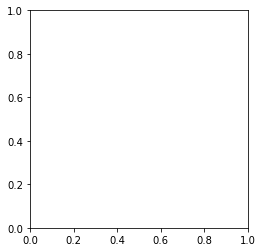

In [5]:
plt.imshow(train_y[0].shape)

In [5]:
#the form of data is:
#data[0] is a list with all rgb img's as tensor
#data[1] is a list with all targets as tensor  
def Get_stats(data):
    print(f'Number of img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')
    
    
#print some info about data structure
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of img 99
target sahpe (256, 256, 1)
input shape (256, 256, 3)
train_data:
Number of img 1128
target sahpe (256, 256, 1)
input shape (256, 256, 3)


# One hot encoder

In [6]:
#make the one hot encoder on test and train
depth = 9
test_y=tf.one_hot(test_y, depth)[:,:,:,0,:]
train_y=tf.one_hot(train_y, depth)[:,:,:,0,:]

In [7]:
#print some info about data structure
print('test_data:')
Get_stats([test_x,test_y,])
print('train_data:')
Get_stats([train_x,train_y,])

test_data:
Number of img 99
target sahpe (256, 256, 9)
input shape (256, 256, 3)
train_data:
Number of img 1128
target sahpe (256, 256, 9)
input shape (256, 256, 3)


# loss

In [8]:
#creat loss
def dise(y, y_pred):
        y_true_f = K.flatten(y)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f))
        return -dice

In [9]:
#Creat Unet structure currently without Dropout
leakyrelu_alpha = 0.3
dr_rate = 0.6
def unet(pretrained_weights=None, input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)    
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(dr_rate)(pool1) ### 
    
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)
    #conv2 = Dropout(dr_rate)(conv2)###
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)    
    #conv2 = Dropout(dr_rate)(conv2)###    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)    
    #conv4 = Dropout(dr_rate)(conv4) ###
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)
    drop4 = Dropout(dr_rate)(conv4) ###
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    

    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)    
    conv5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #conv5 = Dropout(dr_rate)(conv5) ###
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #drop5 = Dropout(dr_rate)(conv5) ###

    up6 = Conv2D(512, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU(alpha=leakyrelu_alpha)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)
    #conv6 = Dropout(dr_rate)(conv6) ###
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)    
    #conv6 = Dropout(dr_rate)(conv6) ###   

    up7 = Conv2D(256, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = BatchNormalization()(up7)    
    up7 = LeakyReLU(alpha=leakyrelu_alpha)(up7)
    up7 = Dropout(dr_rate)(up7) ###
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)    
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)    
    #conv7 = Dropout(dr_rate)(conv7) ###
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)
    #conv7 = Dropout(dr_rate)(conv7) ###   

    up8 = Conv2D(128, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.3)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = LeakyReLU(alpha=0.3)(conv8)
    #conv8 = Dropout(dr_rate)(conv8) ###
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)    
    conv8 = LeakyReLU(alpha=0.3)(conv8)    
    #conv8 = Dropout(dr_rate)(conv8) ###    

    up9 = Conv2D(64, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=leakyrelu_alpha)(up9)
    up9 = Dropout(dr_rate)(up9) ###
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)    
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv10 = Conv2D(9, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    # create our Dice_loss
    def Dise_lose(y, y_pred):
        y_true_f = K.flatten(y)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f))
        return -dice
    # compile the model with the Dice_lose
    model.compile(optimizer=Adam(learning_rate=1e-2), loss=Dise_lose)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 rmalization)                   )                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 16, 16, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 1024  9438208     ['leaky_re_lu_8[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 1024  4096       ['conv2d_9[0][0]']               
 rmalization)                   )                                                                 
          

 conv2d_17 (Conv2D)             (None, 128, 128, 12  295040      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 12  512        ['conv2d_17[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 128, 128, 12  0           ['batch_normalization_16[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 12  147584      ['leaky_re_lu_17[0][0]']         
          

In [10]:
#makes generator that splits data into batches
class batches(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array(batch_x),np.array(batch_y)

In [11]:
# creates the batches
batch_size=1
train_data_batches = batches(train_x,train_y,batch_size)


In [12]:
#Fit the model 
history = model.fit(train_data_batches, epochs=4,steps_per_epoch=52)#, steps_per_epoch=5

Epoch 1/4
52/52 [==============================] - 920s 18s/step - loss: -0.3564
Epoch 2/4
52/52 [==============================] - 941s 18s/step - loss: -0.7977
Epoch 3/4
52/52 [==============================] - 1022s 20s/step - loss: -0.8641
Epoch 4/4
52/52 [==============================] - 1061s 20s/step - loss: -0.8732


In [13]:
#test the test set
test_data_resuls = batches(test_x,test_y,1)
result = model.predict(test_data_resuls)

99/99 [==============================] - 67s 658ms/step


In [14]:
#print all the test losses 
for i in range(99):
    print(f'idx {i}')
    print(np.array(dise(result[i],test_y[i])))
    print("")

idx 0
-0.7758443

idx 1
-0.7527611

idx 2
-0.8168756

idx 3
-0.49275285

idx 4
-0.72265047

idx 5
-0.75194067

idx 6
-0.72608745

idx 7
-0.62922484

idx 8
-0.65110457

idx 9
-0.80883634

idx 10
-0.6728543

idx 11
-0.81840044

idx 12
-0.79261214

idx 13
-0.77452075

idx 14
-0.81145203

idx 15
-0.68004775

idx 16
-0.71938145

idx 17
-0.7325647

idx 18
-0.5790343

idx 19
-0.82930976

idx 20
-0.7141162

idx 21
-0.7632743

idx 22
-0.66874075

idx 23
-0.77490515

idx 24
-0.7028603

idx 25
-0.6975053

idx 26
-0.738206

idx 27
-0.83987623

idx 28
-0.73116636

idx 29
-0.78880966

idx 30
-0.60988474

idx 31
-0.744123

idx 32
-0.7444187

idx 33
-0.71777827

idx 34
-0.7163954

idx 35
-0.8132199

idx 36
-0.8163411

idx 37
-0.8609599

idx 38
-0.7377014

idx 39
-0.66946816

idx 40
-0.79161364

idx 41
-0.7626374

idx 42
-0.627849

idx 43
-0.64599735

idx 44
-0.7226329

idx 45
-0.73570776

idx 46
-0.7298131

idx 47
-0.7991276

idx 48
-0.6276916

idx 49
-0.7749125

idx 50
-0.7429362

idx 51
-0.792942

i

<function matplotlib.pyplot.show(close=None, block=None)>

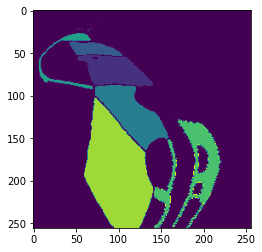

In [19]:
#plots true label
plt.imshow(tf.argmax(test_y[10],axis=-1))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

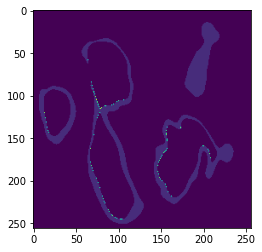

In [23]:
#plots prediction 
plt.imshow(tf.argmax(result[10],axis=-1))
plt.show